# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled final model along with this notebook.

The group with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import the RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.** <mark>The objective is to predict whether there will be an early Spring, allowing farmers to decide whether to purchase a new kind of corn seed that can grow two crops. Early Spring is defined as a period when the average temperature is above 40°F, the minimum temperature is above 32°F, and the average soil temperature is above 50°F before April 1st, with no snow on the ground.</mark>
2. **How will your solution be used?** <mark>The solution will be used by farmers in western PA to make informed decisions about purchasing seeds by February 25th. The prediction will help them determine if conditions will be favorable for planting the new corn seed early.</mark>
3. **What are the current solutions/workarounds (if any)?** <mark>Currently, farmers rely on Punxsutawney Phil's prediction, which is not very accurate. They may also use historical weather data and personal experience to make decisions.</mark>
4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?** <mark>This problem should be framed as a supervised learning problem, where the goal is to predict a binary outcome (early Spring or not) based on historical weather and soil data. This will be a classification model, using offline learning since the most important data involves winter and spring only.</mark>
5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Performance should be measured using accuracy, precision, recall, and F1-score. Since the preference is to avoid false negatives (missing an early Spring), recall might be particularly important.</mark>
6. **What would be the minimum performance needed to reach the business objective?** <mark>The minimum performance needed would be a recall rate that ensures farmers can confidently make purchasing decisions with minimal risk of missing an early Spring.</mark>
7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools from the MNIST in-class notebook to help with this model, especially with working with binary classifiers and a classification model. </mark>
8. **Is human expertise available?** <mark>Yes, human expertise is available from the farmers who have historical data and experience with weather patterns and planting conditions.</mark>
9. **How would you solve the problem manually?** <mark>I would solve this manually by focusing on the weather conditions, soil conditions, temperature of both weather and soil, whether or not there is snow cosverage within the land in Western PA. </mark>
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** <mark>TODO</mark>

Get the Data
=======================================================================

1. **List the data you need and how much you need.** <mark>We need data to predict either an early spring, or late winter. To do that we need weather, soil, and a dataset which gives us a label feature like early spring. Also could use El Nino or La Nina data to predict this.</mark>
2. **Find and document where you can get that data:** <mark>From the client for first 3 datasets. From https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php for El Nino and La Nina data</mark>
3. **Get access authorizations:** <mark>Done</mark>
4. **Create a workspace (with enough storage space)**: This notebook.
5. **Get the data:** <mark>Got the data.</mark>
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done.
8. **Check the size and type of data (time series, geographical, …):** <mark>TODO</mark> - complete in the cells below
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** <mark>TODO</mark> - complete in the cells below

In [2]:
def load_and_concat_datasets(weather_file, soil_file, output_file='data.csv'):
    # Convert the 'date' in weather and 'day' in soil to datetime for proper merging
    weather_file['date'] = pd.to_datetime(weather_file['date'])
    soil_file['day'] = pd.to_datetime(soil_file['day'])

    # Merge the weather and soil data on 'date' and 'day'
    combined_df = pd.merge(weather_file, soil_file, left_on='date', right_on='day', how='inner')

    # Display the first few rows of the final combined DataFrame
    print(combined_df.head())

    # Save the final combined DataFrame to a CSV file
    combined_df.to_csv(output_file, index=False)

    return combined_df



def stratify_precipitation(data, precipitation_col):
    """
    Stratify precipitation into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the precipitation data.
    - precipitation_col: The name of the column containing precipitation values.

    Returns:
    - DataFrame with a new column 'precipitation_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[precipitation_col] == 0),               # No precipitation
        (data[precipitation_col] > 0) & (data[precipitation_col] <= 0.1),  # Light precipitation
        (data[precipitation_col] > 0.1) & (data[precipitation_col] <= 0.5),  # Moderate precipitation
        (data[precipitation_col] > 0.5)               # Heavy precipitation
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'precipitation_category'
    data['precipitation_category'] = pd.cut(
        data[precipitation_col],
        bins=[-float('inf'), 0, 0.1, 0.5, float('inf')],
        labels=categories,
        right=True
    )

    return data



def stratify_snowfall(data, snowfall_col):
    """
    Stratify snowfall into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the snowfall data.
    - snowfall_col: The name of the column containing snowfall values.

    Returns:
    - DataFrame with a new column 'snowfall_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[snowfall_col] == 0),            # No snowfall
        (data[snowfall_col] > 0) & (data[snowfall_col] <= 1),  # Light snowfall
        (data[snowfall_col] > 1) & (data[snowfall_col] <= 5),  # Moderate snowfall
        (data[snowfall_col] > 5)              # Heavy snowfall
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'snowfall_category'
    data['snowfall_category'] = pd.cut(
        data[snowfall_col],
        bins=[-float('inf'), 0, 1, 5, float('inf')],
        labels=categories,
        right=True
    )

    return data

def stratify_snowdepth(data, snowfall_col):
    """
    Stratify snowfall into categories based on custom thresholds.

    Parameters:
    - data: DataFrame containing the snowfall data.
    - snowfall_col: The name of the column containing snowfall values.

    Returns:
    - DataFrame with a new column 'snowfall_category' added.
    """
    # Define conditions for categorization based on custom thresholds
    conditions = [
        (data[snowfall_col] == 0),                        # No snowfall
        (data[snowfall_col] > 0) & (data[snowfall_col] <= 2),   # Light snowfall
        (data[snowfall_col] > 2) & (data[snowfall_col] <= 9),   # Moderate snowfall
        (data[snowfall_col] > 9) # Heavy snowfall
    ]

    # Define category labels
    categories = ['none', 'light', 'moderate', 'heavy']

    # Create the new column 'snowfall_category'
    data['snowdepth_category'] = pd.cut(
        data[snowfall_col],
        bins=[-float('inf'), 0, 2, 9, float('inf')],
        labels=categories,
        right=True
    )

    return data


def read_weather_data(filename):
    """
    Reads weather data from the given file. M values are assumed to be
    missing values (returned as nan). T values are trace values and returned as
    0.0025 inches for precipitation and snowfall and 0.025 inches for snowdepth
    (see https://www.chicagotribune.com/news/weather/ct-wea-asktom-0415-20180413-column.html).
    All temperatures are in Fahrenheit and all precipitation values are in inches.
    """
    def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    return pd.read_csv(filename, na_values=['M'], parse_dates=[0],
        converters={
            "precipitation":convert_precipitation,
            "snowfall":convert_precipitation,
            "snowdepth":convert_depth,
        },
        names=["date","max_temp","min_temp","avg_temp","precipitation","snowfall","snowdepth"],
        header=0)

def read_soil_data(filename):
    """
    Reads soil data from the given file.
    All temperatures are in Celsius and all moisture values are in wfv (m^3/m^3).
    """
    return pd.read_csv(filename, parse_dates=[0])




In [3]:
# read csv file
soilData = read_soil_data('soil.csv')
weatherData = read_weather_data('weather.csv')
earlySpring = pd.read_csv('early_spring.csv')

data = load_and_concat_datasets(weatherData, soilData, 'data.csv')

        date  max_temp  min_temp  avg_temp  precipitation  snowfall  \
0 1947-01-01      30.0      24.0      27.0           0.12       0.5   
1 1947-01-02      44.0      29.0      36.5           0.49       0.0   
2 1947-01-03      54.0      41.0      47.5           0.04       0.0   
3 1947-01-04      42.0      24.0      33.0           0.00       0.0   
4 1947-01-05      33.0      25.0      29.0           0.00       0.0   

   snowdepth        day  mean_soil_temp  mean_soil_moisture  min_soil_temp  \
0        1.0 1947-01-01       -3.220000            0.477200           -4.1   
1        0.0 1947-01-02       -2.533333            0.498333           -3.2   
2        NaN 1947-01-03       -1.733333            0.515000           -2.7   
3        NaN 1947-01-04        0.729167            0.496625           -0.1   
4        NaN 1947-01-05        0.162500            0.485792           -0.7   

   min_soil_moisture  max_soil_temp  max_soil_moisture  
0              0.475           -1.4            

In [4]:
# Generate a date range for each year from 1947 to 2024, limited to Jan 1 to Feb 25
date_range = pd.date_range(start='1947-01-01', end='2024-02-25', freq='D')

# Filter to keep only dates from January 1 to February 25 of each year
date_range_filtered = date_range[(date_range.month == 1) | ((date_range.month == 2) & (date_range.day <= 25))]

# Remove values from data that are not in date range
data = data[data['date'].isin(date_range_filtered)]

# Filter the date range to only include January and February (Jan 1 to Feb 25)
january_february_range = date_range_filtered

# Find any missing dates in the 'date' column
missing_dates = january_february_range[~january_february_range.isin(data['date'])]

# Display the missing dates
missing_dates

DatetimeIndex(['1958-01-01', '1958-01-02', '1958-01-03', '1958-01-04',
               '1958-01-05', '1958-01-06', '1958-01-07', '1958-01-08',
               '1958-01-09', '1958-01-10',
               ...
               '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23',
               '2019-02-24', '2019-02-25'],
              dtype='datetime64[ns]', length=448, freq=None)

In [5]:
# Create a DataFrame for the missing dates
missing_dates_df = pd.DataFrame({'date': missing_dates})

# Combine the original data with the missing dates
combined_data = pd.concat([data, missing_dates_df])

#Sort the combined data by date
data = combined_data.sort_values(by='date').reset_index(drop=True)


In [6]:
#show every column
pd.set_option('display.max_columns', None)
dat = data.copy()
dat['year'] = dat.date.dt.year
dat['day_of_year'] = dat.date.dt.dayofyear
dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
dat.columns = ["_".join([str(x) for x in a]) for a in dat.columns.to_flat_index()]

In [7]:
#set index of earlySpring to year
earlySpring = earlySpring.sort_values(by='year').reset_index(drop=True)

# Create a DataFrame with all years from the minimum to the maximum year
all_years = pd.DataFrame({'year': range(earlySpring['year'].min(), earlySpring['year'].max() + 1)})

# Merge with the original DataFrame
merged_earlySpring = pd.merge(all_years, earlySpring, on='year', how='left')

# Fill NaN for early_spring where data is not available
merged_earlySpring['early_spring'] = merged_earlySpring['early_spring'].fillna(np.nan)



In [8]:
earlySpring = merged_earlySpring.set_index('year')

In [9]:
data = dat.join(earlySpring, how='inner')

In [10]:
# read ExtraDataONI.csv
oni_data = pd.read_csv('ExtraDataONI.csv')

oni_data = oni_data.set_index('year')
oni_data
# merge data with oni_data
data = data.join(oni_data, how='inner')

In [11]:
# If there are categorical columns, list their unique values and counts
for col in data.select_dtypes(include=['object']).columns:
    print(f"Unique values for {col}:")
    print(data[col].value_counts())

Unique values for early_spring:
early_spring
False    35
True     35
Name: count, dtype: int64


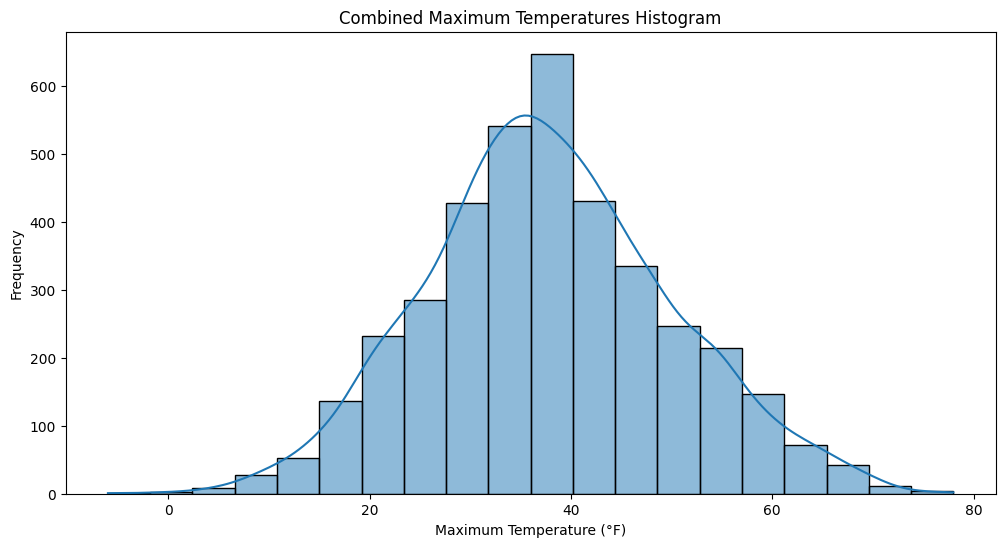

In [12]:
max_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_temp' in col], 
                           var_name='Temperature_Type', value_name='Max_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_temp_values['Max_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Maximum Temperatures Histogram')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

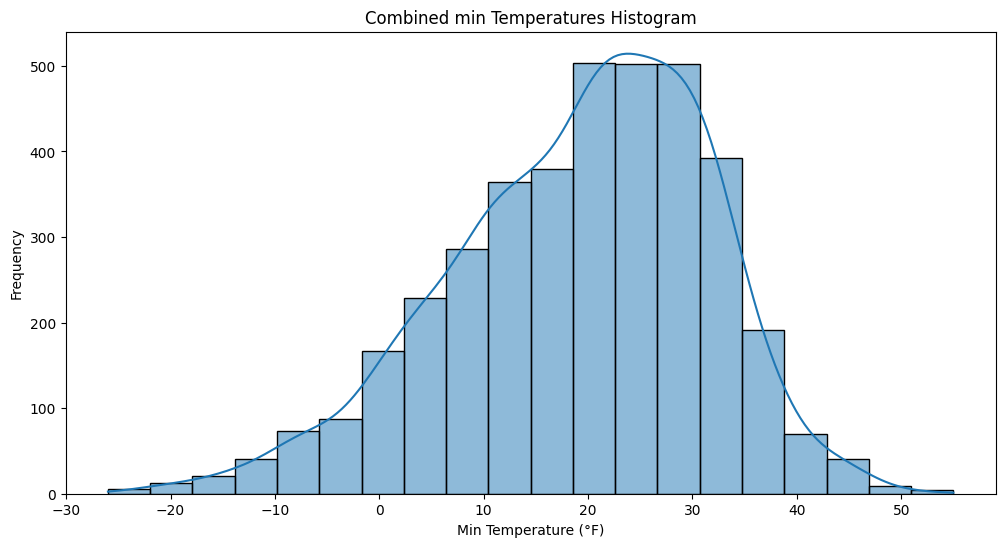

In [13]:
min_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_temp' in col], 
                           var_name='Temperature_Type', value_name='Min_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_temp_values['Min_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined min Temperatures Histogram')
plt.xlabel('Min Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

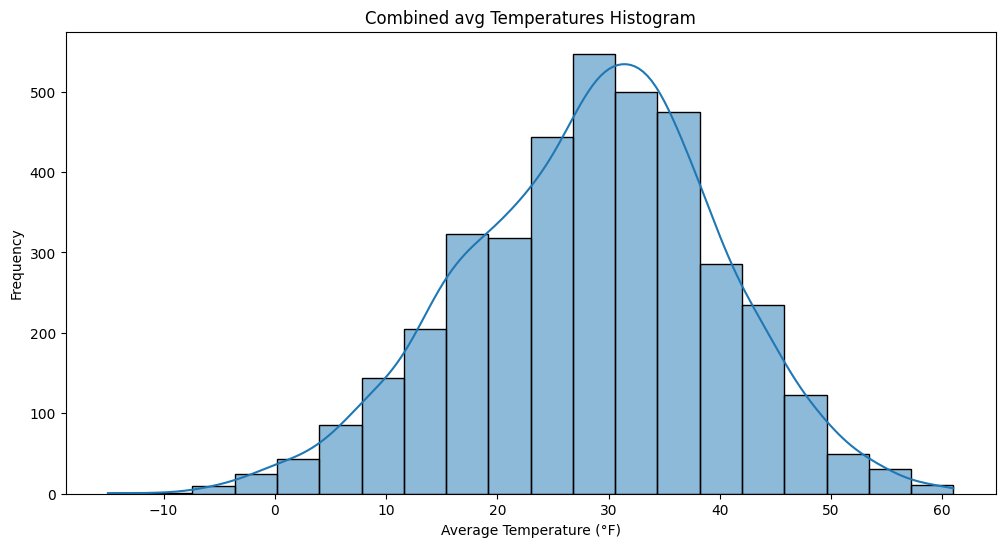

In [14]:
avg_temp_values = pd.melt(data, value_vars=[col for col in data if 'avg_temp' in col], 
                           var_name='Temperature_Type', value_name='Avg_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(avg_temp_values['Avg_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined avg Temperatures Histogram')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

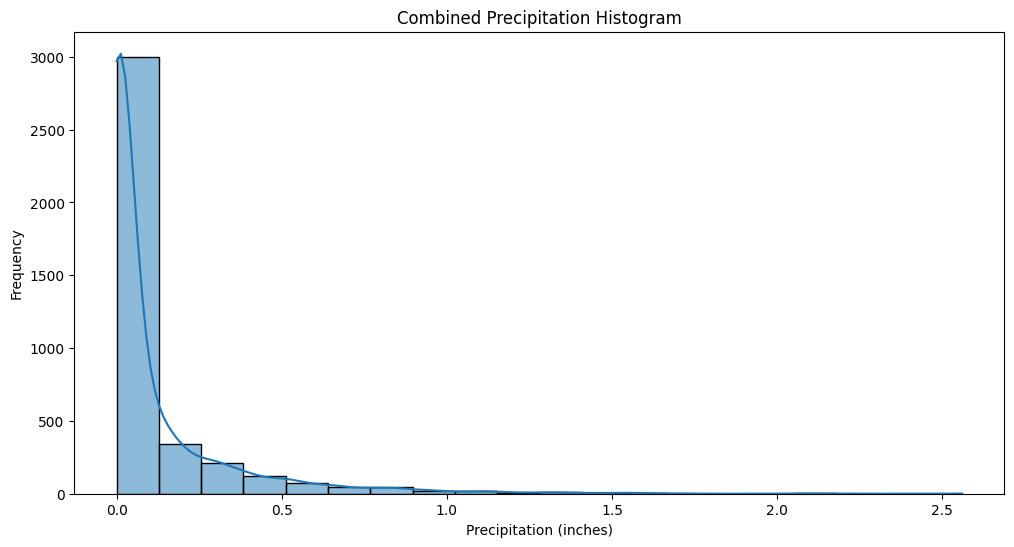

In [15]:
precipitation_values = pd.melt(data, value_vars=[col for col in data if 'precipitation' in col],
                                 var_name='Precipitation_Type', value_name='Precipitation')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(precipitation_values['Precipitation'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Precipitation Histogram')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

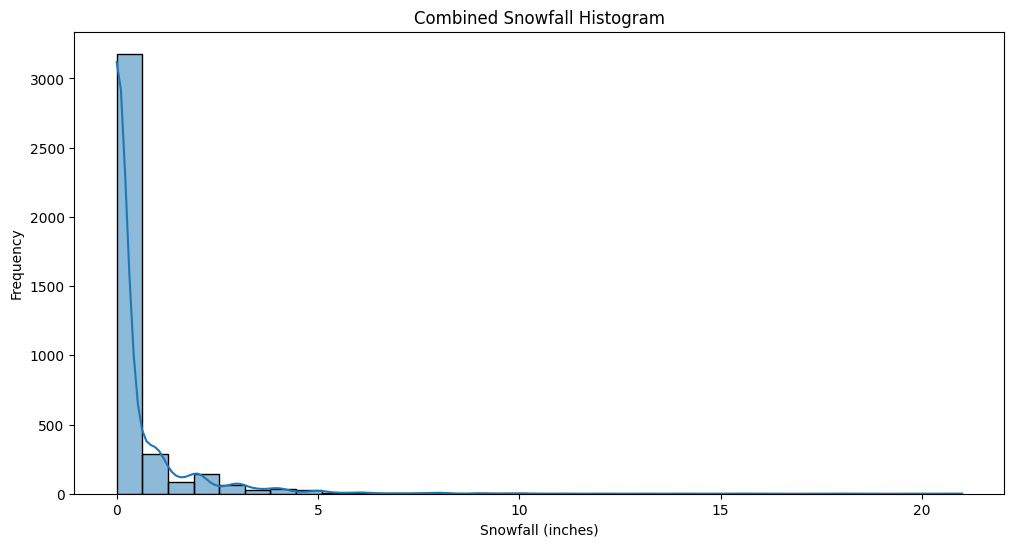

In [16]:
snowfall_values = pd.melt(data, value_vars=[col for col in data if 'snowfall' in col],
                                    var_name='Snowfall_Type', value_name='Snowfall')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowfall_values['Snowfall'], bins=33, kde=True)

# Add labels and title
plt.title('Combined Snowfall Histogram')
plt.xlabel('Snowfall (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

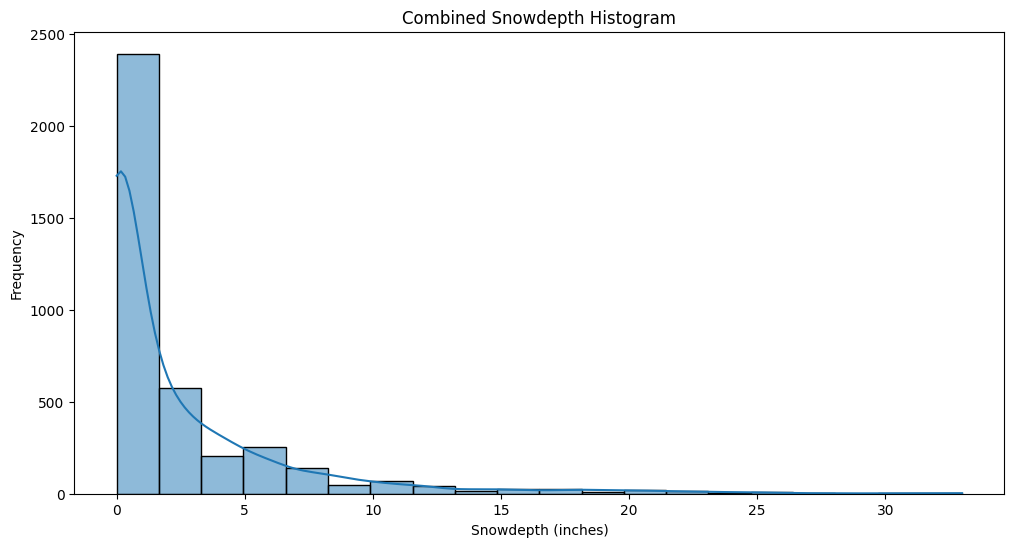

In [17]:
snowdepth_values = pd.melt(data, value_vars=[col for col in data if 'snowdepth' in col],
                                    var_name='Snowdepth_Type', value_name='Snowdepth')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowdepth_values['Snowdepth'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Snowdepth Histogram')
plt.xlabel('Snowdepth (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

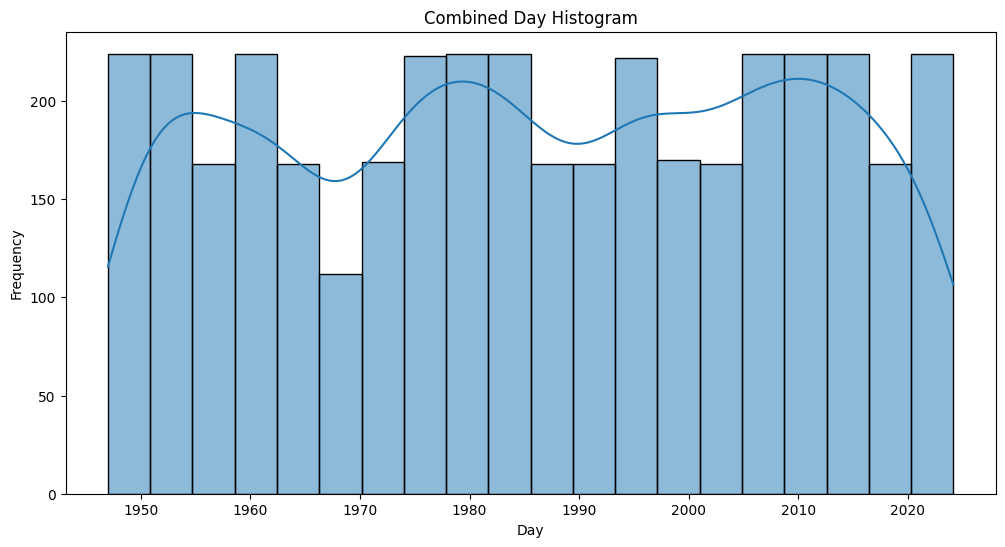

In [18]:
day_values = pd.melt(data, value_vars=[col for col in data if 'day' in col],
                                    var_name='Day_Type', value_name='Day')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(day_values['Day'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Day Histogram')
plt.xlabel('Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

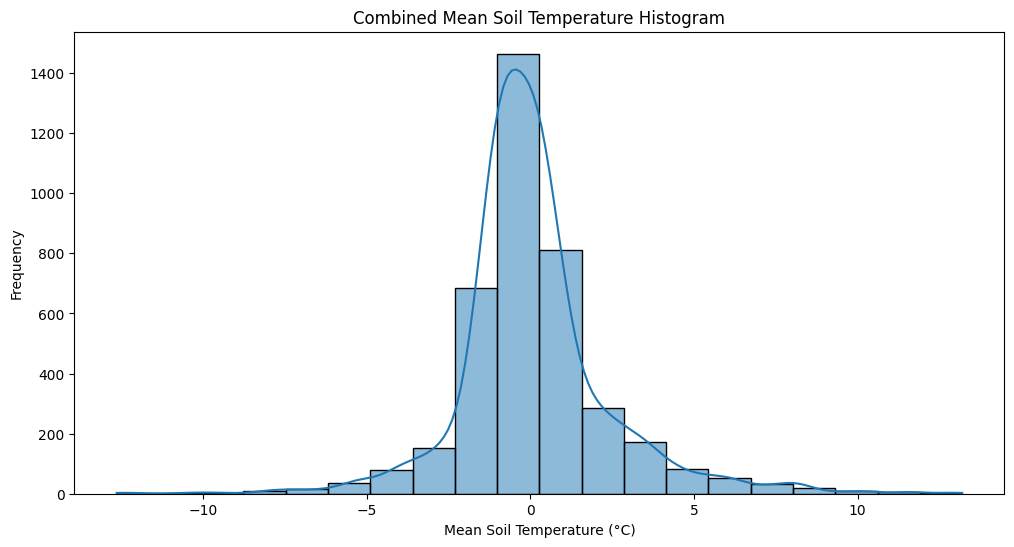

In [19]:
mean_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_temp' in col],
                                    var_name='Mean_Soil_Temperature_Type', value_name='Mean_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_temp_values['Mean_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Temperature Histogram')
plt.xlabel('Mean Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

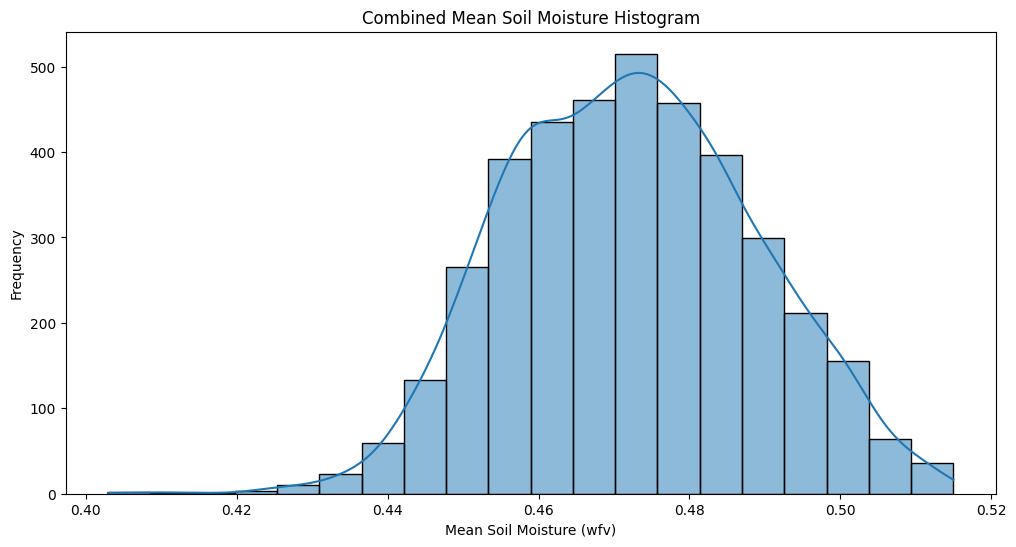

In [20]:
mean_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_moisture' in col],
                                    var_name='Mean_Soil_Moisture_Type', value_name='Mean_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_moisture_values['Mean_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Moisture Histogram')
plt.xlabel('Mean Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

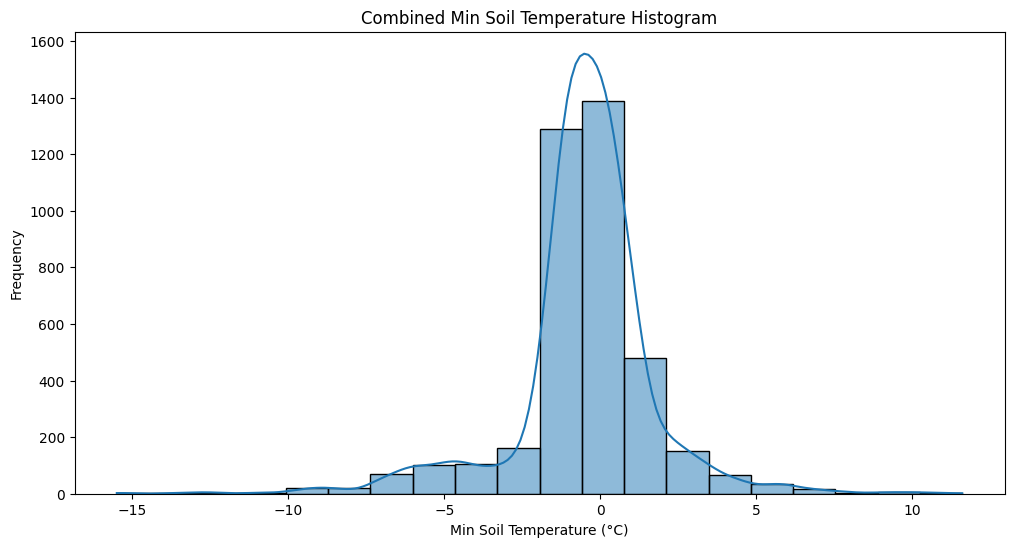

In [21]:
min_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_temp' in col],
                                    var_name='Min_Soil_Temperature_Type', value_name='Min_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_temp_values['Min_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Temperature Histogram')
plt.xlabel('Min Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

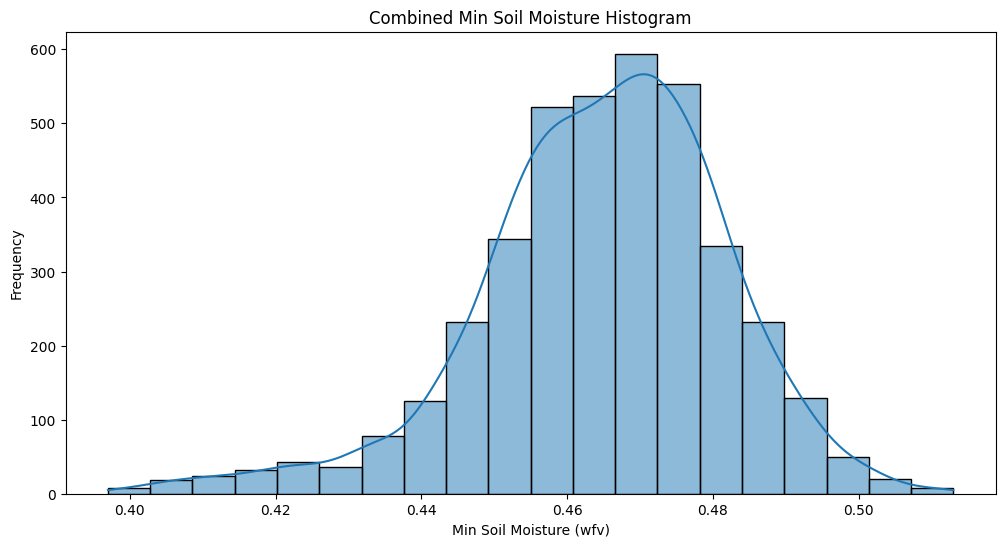

In [22]:
min_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_moisture' in col],
                                    var_name='Min_Soil_Moisture_Type', value_name='Min_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_moisture_values['Min_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Moisture Histogram')
plt.xlabel('Min Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


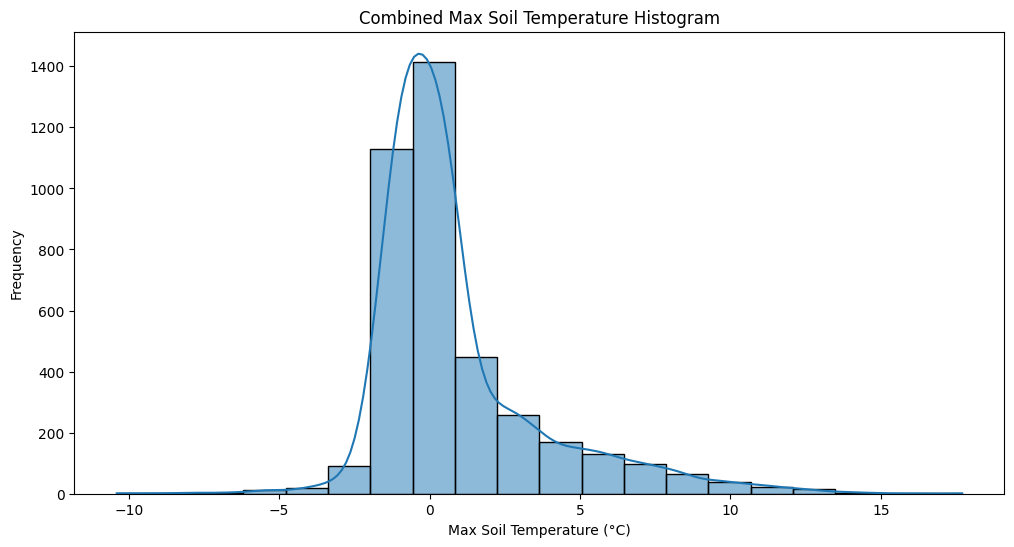

In [23]:
max_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_temp' in col],
                                    var_name='Max_Soil_Temperature_Type', value_name='Max_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_temp_values['Max_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Temperature Histogram')
plt.xlabel('Max Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


### Splitting Data

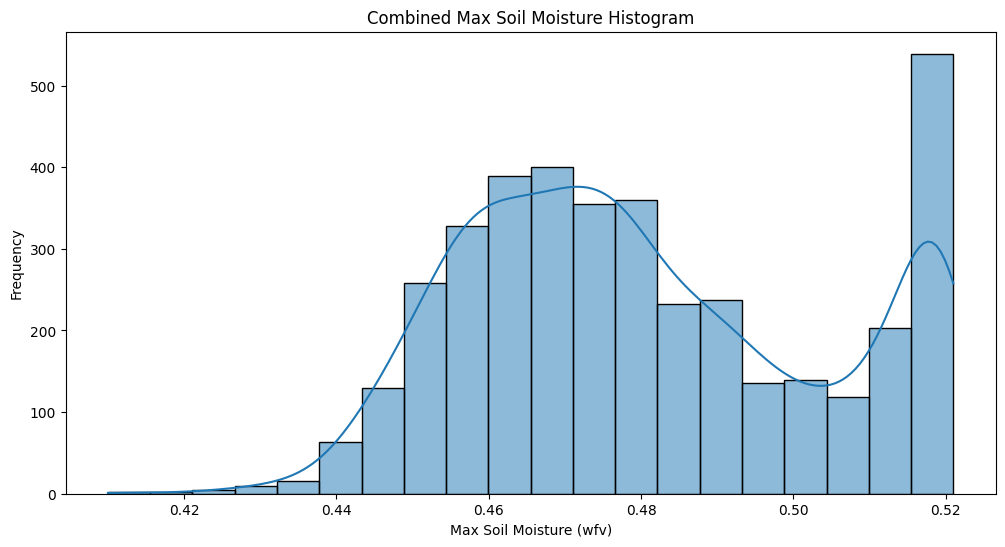

In [24]:
max_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_moisture' in col],
                                    var_name='Max_Soil_Moisture_Type', value_name='Max_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_moisture_values['Max_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Moisture Histogram')
plt.xlabel('Max Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

<Axes: xlabel='DJF', ylabel='Count'>

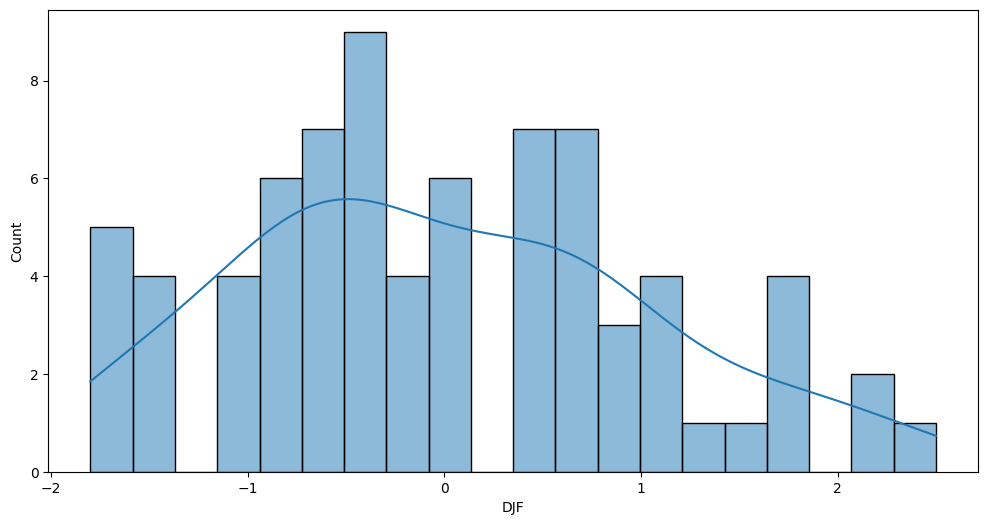

In [25]:
#plot DJF variable in data

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['DJF'], bins=20, kde=True)

<Axes: xlabel='JFM', ylabel='Count'>

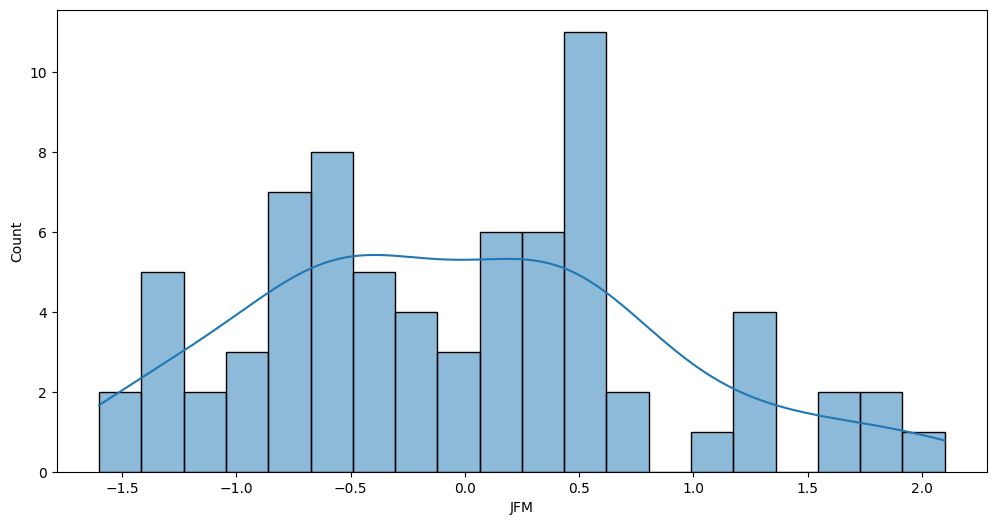

In [26]:
#plot JFM
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JFM'], bins=20, kde=True)

<Axes: xlabel='FMA', ylabel='Count'>

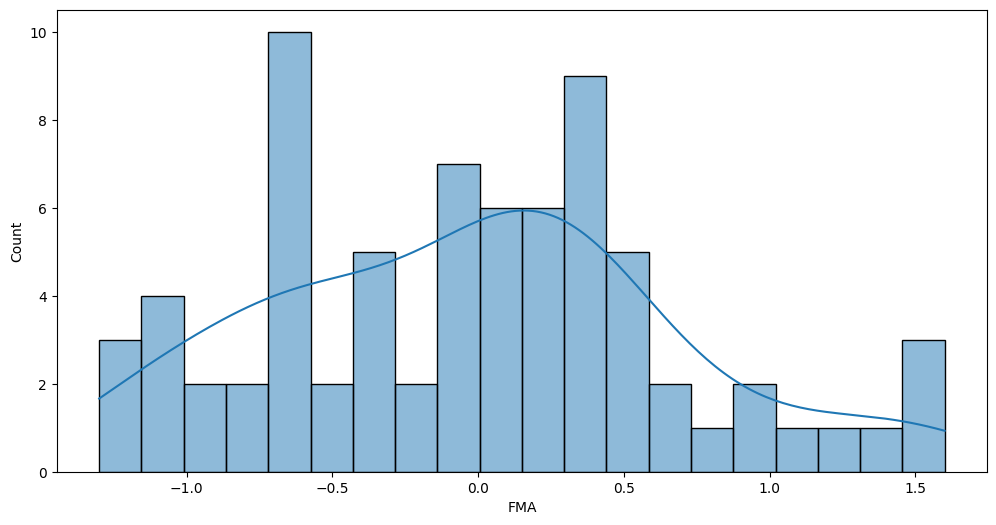

In [27]:
#plot FMA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['FMA'], bins=20, kde=True)

<Axes: xlabel='MAM', ylabel='Count'>

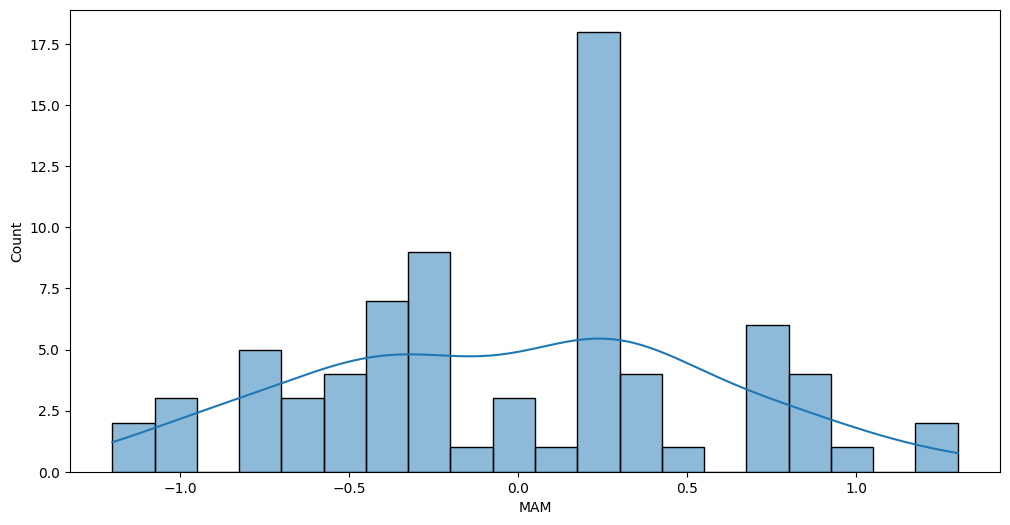

In [28]:
#plot MAM

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MAM'], bins=20, kde=True)

<Axes: xlabel='AMJ', ylabel='Count'>

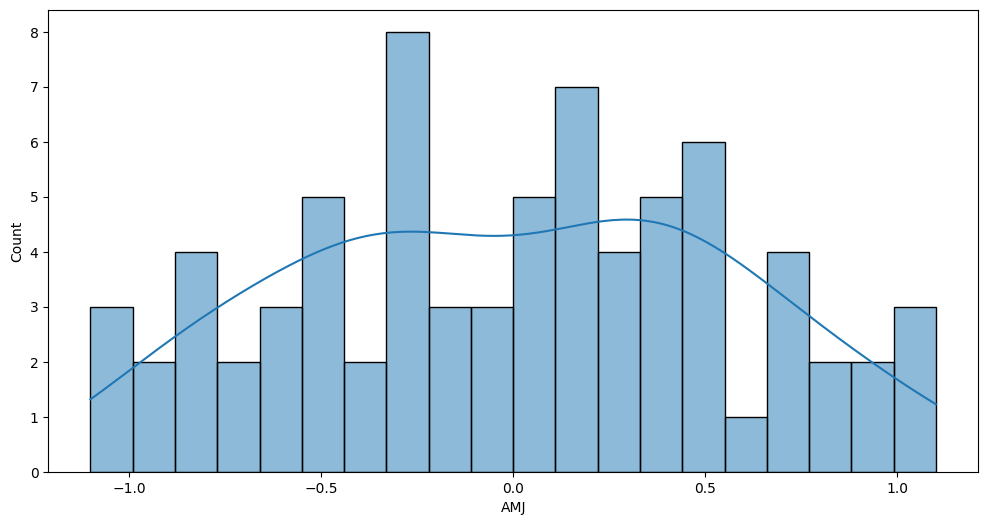

In [29]:
#plot AMJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['AMJ'], bins=20, kde=True)

<Axes: xlabel='MJJ', ylabel='Count'>

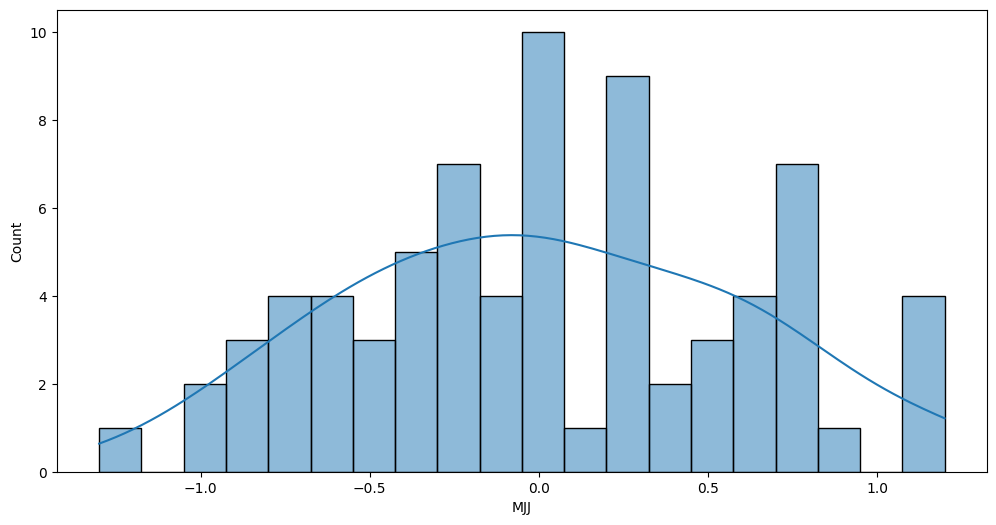

In [30]:
#plot MJJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MJJ'], bins=20, kde=True)

<Axes: xlabel='JJA', ylabel='Count'>

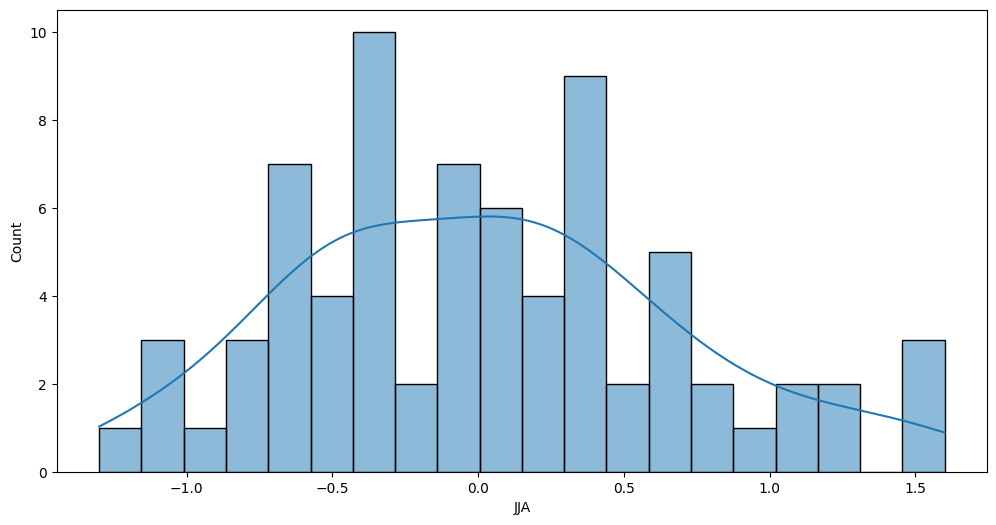

In [31]:
#plot JJA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JJA'], bins=20, kde=True)

<Axes: xlabel='JAS', ylabel='Count'>

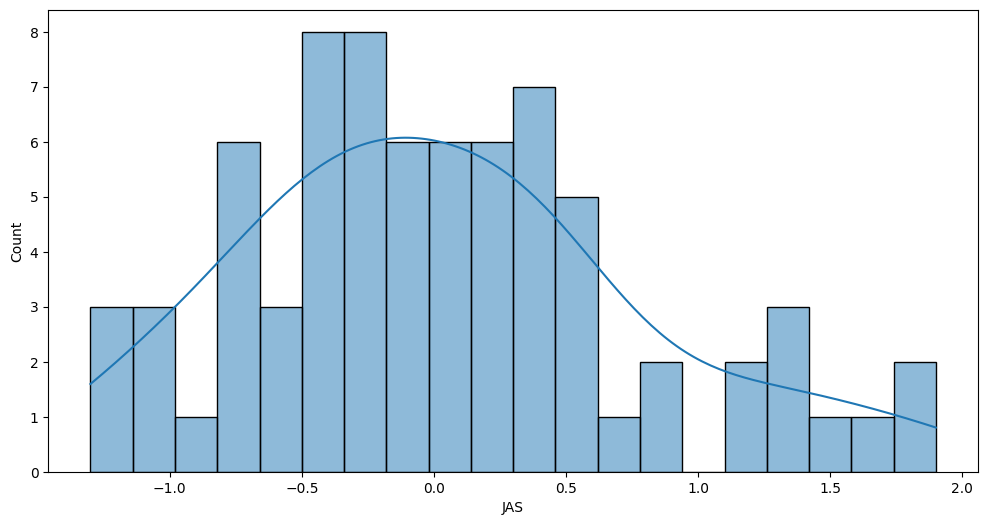

In [32]:
#plot JAS

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['JAS'], bins=20, kde=True)

<Axes: xlabel='ASO', ylabel='Count'>

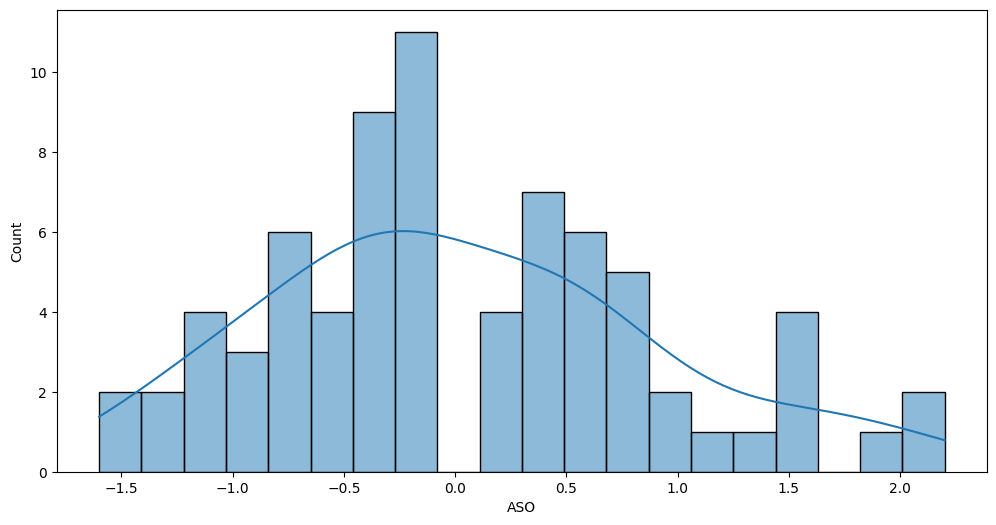

In [33]:
#plot ASO

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['ASO'], bins=20, kde=True)

<Axes: xlabel='SON', ylabel='Count'>

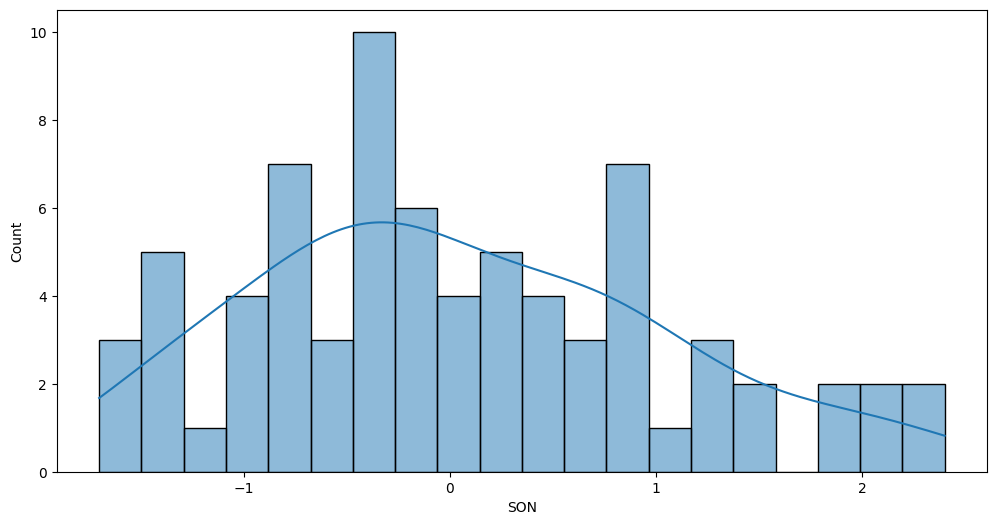

In [34]:
#plot SON

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['SON'], bins=20, kde=True)

<Axes: xlabel='OND', ylabel='Count'>

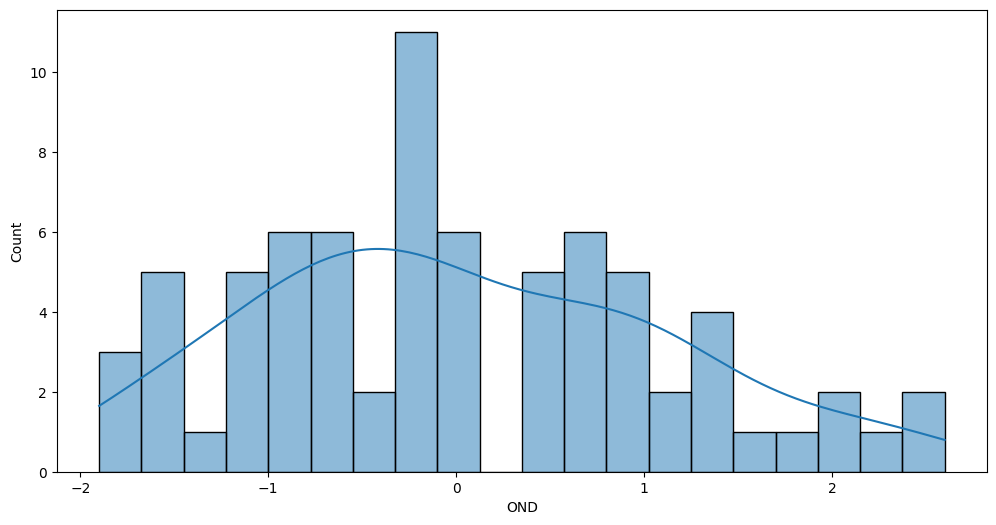

In [35]:
#plot OND

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['OND'], bins=20, kde=True)

<Axes: xlabel='NDJ', ylabel='Count'>

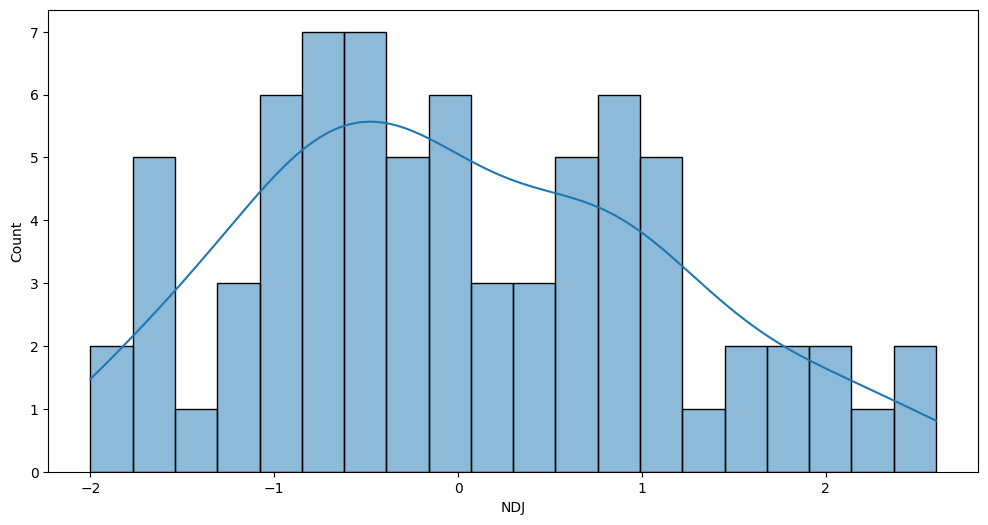

In [36]:
#plot NDJ

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['NDJ'], bins=20, kde=True)

<Axes: xlabel='early_spring', ylabel='Count'>

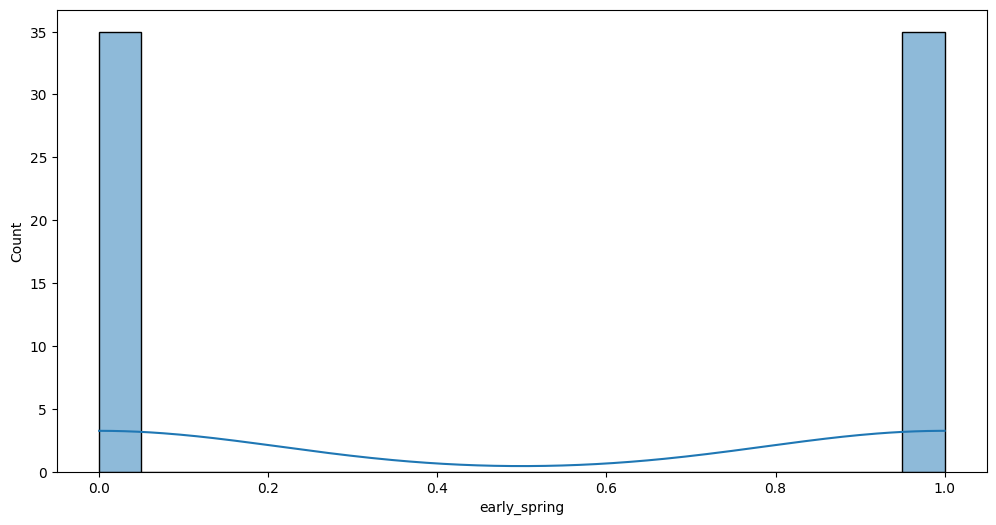

In [37]:
#early_spring

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['early_spring'], bins=20, kde=True)

In [38]:
#code to check which values of early spring are NAN
data[data['early_spring'].isnull()]

#drop rows with NAN values
data = data.dropna(subset=['early_spring'])

data['early_spring'].value_counts()

early_spring
False    35
True     35
Name: count, dtype: int64

In [39]:
#drop any columns with day from data
data = data.drop(columns=[col for col in data if 'day' in col])

In [40]:
from sklearn.model_selection import train_test_split

# Perform the train-test split on the filtered data stratifying early_spring
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['early_spring'])

## Get the Data Notes

- Took 10% for test because of small data size
- Filled NAN values of early_spring with unknown and converted true and false to strings so I could stratify. 

Things I'm interested in for data visualizaion
- Do different days have more or less of an effect on whether its an early spring or not?

- dropped Day columns because they are completely useless now that we used the date column to separate out many other features.

# Explore the Data

In [41]:
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Check for outliers in numerical columns
for col in train_data.select_dtypes(include=['float64', 'int64']).columns:
    print(f"Outliers in {col}:")
    print(detect_outliers(data[col]).shape)

Outliers in max_temp_1:
(5,)
Outliers in max_temp_2:
(0,)
Outliers in max_temp_3:
(0,)
Outliers in max_temp_4:
(0,)
Outliers in max_temp_5:
(4,)
Outliers in max_temp_6:
(1,)
Outliers in max_temp_7:
(3,)
Outliers in max_temp_8:
(2,)
Outliers in max_temp_9:
(0,)
Outliers in max_temp_10:
(0,)
Outliers in max_temp_11:
(0,)
Outliers in max_temp_12:
(0,)
Outliers in max_temp_13:
(3,)
Outliers in max_temp_14:
(0,)
Outliers in max_temp_15:
(0,)
Outliers in max_temp_16:
(0,)
Outliers in max_temp_17:
(1,)
Outliers in max_temp_18:
(0,)
Outliers in max_temp_19:
(1,)
Outliers in max_temp_20:
(1,)
Outliers in max_temp_21:
(2,)
Outliers in max_temp_22:
(0,)
Outliers in max_temp_23:
(3,)
Outliers in max_temp_24:
(0,)
Outliers in max_temp_25:
(1,)
Outliers in max_temp_26:
(0,)
Outliers in max_temp_27:
(1,)
Outliers in max_temp_28:
(2,)
Outliers in max_temp_29:
(2,)
Outliers in max_temp_30:
(0,)
Outliers in max_temp_31:
(1,)
Outliers in max_temp_32:
(5,)
Outliers in max_temp_33:
(0,)
Outliers in max_tem

| Feature             | Type       | % Missing Values | Noisiness (Outliers, Gaps, etc.) | Usefulness (Business Goal) | Distribution                  |
|---------------------|------------|------------------|----------------------------------|-----------------------------|-------------------------------|
| **date**            | datetime | 0%               | Some missing time periods        | Useful, indicates seasonality| Fairly uniform but has gaps   |
| **max_temp**        | numerical    | 16.360095%            | Outliers detected (17)           | Highly useful (affects early spring)| Normal distribution with slight skew |
| **min_temp**        | numerical    | 16.057130%            | Outliers detected (35)           | Highly useful (affects early spring)| Normal distribution with slight skew |
| **avg_temp**        | numerical    | 16.576499%            | Outliers detected (23)           | Highly useful (affects early spring)| Normal distribution            |
| **precipitation**   | numerical    | 28.954772%           | Outliers detected (367)          | Somewhat useful (affects snow/soil) | Highly skewed (low values dominate) - Log Normal |
| **snowfall**        | numerical    | 30.404674%           | Outliers detected (418)          | Important for snow coverage | Highly skewed (many zero values) - Log Normal   |
| **snowdepth**       | numerical    | 31.205367%           | Outliers detected (207)          | Useful (indicates snow cover) | Skewed with many zero values - Log Normal     |
| **year**            | datetime      | 15.169877%               | No outliers                      | Key feature for time-based trends | Uniform, as expected for year data |
| **early_spring**    | bool       | 15.169877%               | No issues detected               | Target variable              | Binary: True/False              |
| **day**             | numerical | 15.169877%               | Some missing time periods        | Somewhat useful for daily trends | Appears consistent, but gaps exist |
| **mean_soil_temp**  | numerical    | 15.169877%               | Outliers detected (387)          | Highly relevant (affects planting)| Skewed, some negative values       |
| **mean_soil_moisture** | numerical | 15.169877%               | Outliers detected (7)          | Useful for predicting soil conditions | Skewed, concentrated around a median|
| **min_soil_temp**   | numerical    | 15.169877%               | Outliers detected (115)          | Relevant (soil temperature)  | Skewed, with negative values       |
| **min_soil_moisture**| numerical   | 15.169877%               | Outliers detected (115)            | Some relevance               | Skewed, concentrated in a narrow range|
| **max_soil_temp**   | numerical    | 15.169877%               | Outliers detected (436)          | Relevant for planting decisions | Skewed but centered             |
| **max_soil_moisture**| numerical   | 15.169877%               | No outliers                      | Useful for soil moisture trends | Right-Skewed Distribution               |
| **DJF**            | numerical    | 18.805453%            | Outliers detected (356), Some gaps          | Useful for El Nino changes | Slightly skewed, sort of Normal|

In [45]:
#convert early spring (true for early spring false for late winter) to be 1 for early spring and 0 for late winter

train_data['early_spring'] = train_data['early_spring'].apply(lambda x: 1 if x == True else 0)

In [48]:
#run random forest model on data to find values that have very little influence on early_spring

# Create the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(train_data.drop(columns=['early_spring']), train_data['early_spring'])

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': train_data.drop(columns=['early_spring']).columns,
    'importance': feature_importances
})

# Sort values by importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)


feature_importances_df

,feature,importance
371,mean_soil_temp_36,0.013644
52,max_temp_53,0.011507
388,mean_soil_temp_53,0.011100
282,snowdepth_3,0.010803
539,min_soil_moisture_36,0.009819
...,...,...
366,mean_soil_temp_31,0.000000
99,min_temp_44,0.000000
100,min_temp_45,0.000000
101,min_temp_46,0.000000
